Import all required libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter


## Data Quality Check
Let's first examine the data to understand the quality distributions and check for any anomalies.

In [ ]:
def merge_wine_datasets(df_red, df_white, df_qt):
    # Create copies of the datasets and add wine type indicators
    df_red_copy = df_red.copy()
    df_white_copy = df_white.copy()
    df_qt_copy = df_qt.copy()

    # Add wine type column (one-hot encoding)
    df_red_copy['is_red_wine'] = 1
    df_white_copy['is_red_wine'] = 0
    df_qt_copy['is_red_wine'] = 1

    # Merge the datasets
    df_merged = pd.concat([df_red_copy, df_white_copy, df_qt_copy], ignore_index=True)

    print(f"Merged dataset shape: {df_merged.shape}")
    print(f"Red wine samples: {len(df_red_copy)}")
    print(f"White wine samples: {len(df_white_copy)}")
    print(f"QT samples: {len(df_qt_copy)}")
    print(f"Total samples: {len(df_merged)}")

    return df_merged

In [ ]:
# Load datasets
df_red = pd.read_csv("Data/Raw/Wine_Datasets/UCI_Wines/winequality-red.csv", sep=';')
df_white = pd.read_csv("Data/Raw/Wine_Datasets/UCI_Wines/winequality-white.csv", sep=';')
df_qt = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/WineQT.csv", sep=',').drop(["Id"], axis=1)

datasets = {
    'Red Wine': df_red,
    'White Wine': df_white,
    'Quality Test': df_qt
}
df_merged = merge_wine_datasets(df_red, df_white, df_qt)

# Save merged dataset
# Make directory if it doesn't exist
import os
os.makedirs("Data/Processed", exist_ok=True)
df_merged.to_csv("Data/Processed/merged_wine_quality_data.csv", index=False)

# Variables with high VIFs identified from previous analysis
high_vifs = ['density', 'is_red_wine'] 


Merged dataset shape: (7640, 13)
Red wine samples: 1599
White wine samples: 4898
QT samples: 1143
Total samples: 7640


In [85]:
# Check the quality distributions and data integrity
for name, df in [("Merged Wine", df_merged)]:
    print(f"\n=== {name} Dataset ===")
    print(f"Shape: {df.shape}")
    print(f"Quality column type: {df['quality'].dtype}")
    print(f"Quality value counts:")
    print(df['quality'].value_counts().sort_index())
    print(f"Quality range: {df['quality'].min()} to {df['quality'].max()}")
    
    # Check for any non-integer values or outliers
    print(f"Unique quality values: {sorted(df['quality'].unique())}")
    
    # Check for missing values
    print(f"Missing values in quality: {df['quality'].isnull().sum()}")
    
    # Check data types of all columns
    print(f"Data types:")
    print(df.dtypes)


=== Merged Wine Dataset ===
Shape: (7640, 11)
Quality column type: int64
Quality value counts:
quality
3      36
4     249
5    2621
6    3298
7    1222
8     209
9       5
Name: count, dtype: int64
Quality range: 3 to 9
Unique quality values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Missing values in quality: 0
Data types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


### Class Weighting 
The below section is deprecated. It was explored as an alternative to SMOTE.

In [86]:
# Calculate class weights to address imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate balanced class weights
classes = np.unique(df_merged['quality'])
class_weights_balanced = compute_class_weight('balanced', classes=classes, y=df_merged['quality'])
class_weight_dict = dict(zip(classes, class_weights_balanced))

print("Class distribution:")
print(df_merged['quality'].value_counts().sort_index())

print(f"\nCalculated class weights (balanced):")
for quality_level, weight in class_weight_dict.items():
    count = (df_merged['quality'] == quality_level).sum()
    print(f"Quality {quality_level}: weight = {weight:.3f} (n = {count})")

print(f"\nClass weight ratios (relative to most common class):")
max_count = df_merged['quality'].value_counts().max()
for quality_level in sorted(class_weight_dict.keys()):
    count = (df_merged['quality'] == quality_level).sum()
    ratio = max_count / count
    print(f"Quality {quality_level}: {ratio:.1f}x more weight than majority class")

# We'll use these class weights in our models to address the severe imbalance
print(f"\nClass weight dictionary for models: {class_weight_dict}")

Class distribution:
quality
3      36
4     249
5    2621
6    3298
7    1222
8     209
9       5
Name: count, dtype: int64

Calculated class weights (balanced):
Quality 3: weight = 30.317 (n = 36)
Quality 4: weight = 4.383 (n = 249)
Quality 5: weight = 0.416 (n = 2621)
Quality 6: weight = 0.331 (n = 3298)
Quality 7: weight = 0.893 (n = 1222)
Quality 8: weight = 5.222 (n = 209)
Quality 9: weight = 218.286 (n = 5)

Class weight ratios (relative to most common class):
Quality 3: 91.6x more weight than majority class
Quality 4: 13.2x more weight than majority class
Quality 5: 1.3x more weight than majority class
Quality 6: 1.0x more weight than majority class
Quality 7: 2.7x more weight than majority class
Quality 8: 15.8x more weight than majority class
Quality 9: 659.6x more weight than majority class

Class weight dictionary for models: {np.int64(3): np.float64(30.317460317460316), np.int64(4): np.float64(4.38324727481354), np.int64(5): np.float64(0.4164168528914809), np.int64(6): np.f

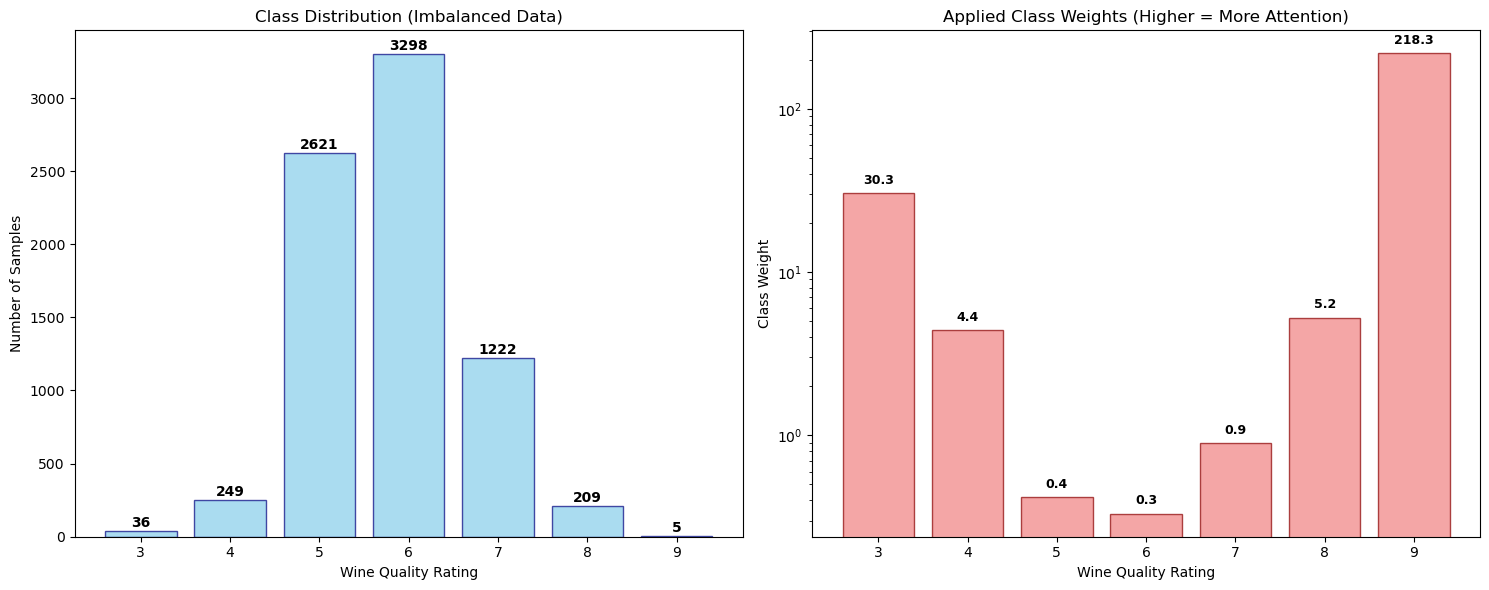

Class weights interpretation:
- Higher weights = Model pays more attention during training
- Quality 9 (rarest): 218x more attention than baseline
- Quality 6 (most common): baseline attention (1x)
- This helps models learn to distinguish rare quality levels


In [ ]:
# Visualize class imbalance and corresponding weights
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

quality_counts = df_merged['quality'].value_counts().sort_index()
quality_levels = quality_counts.index
counts = quality_counts.values

bars1 = ax1.bar(quality_levels, counts, color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_xlabel('Wine Quality Rating')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Class Distribution (Imbalanced Data)')
ax1.set_xticks(quality_levels)

# Add count labels on bars
for bar, count in zip(bars1, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{count}', ha='center', va='bottom', fontweight='bold')

weights = [class_weight_dict[q] for q in quality_levels]
bars2 = ax2.bar(quality_levels, weights, color='lightcoral', edgecolor='darkred', alpha=0.7)
ax2.set_xlabel('Wine Quality Rating')
ax2.set_ylabel('Class Weight')
ax2.set_title('Applied Class Weights (Higher = More Attention)')
ax2.set_xticks(quality_levels)
ax2.set_yscale('log')  # Log scale due to wide range

# Add weight labels on bars
for bar, weight in zip(bars2, weights):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height * 1.1,
             f'{weight:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("Class weights interpretation:")
print("- Higher weights = Model pays more attention during training")
print("- Quality 9 (rarest): 218x more attention than baseline") 
print("- Quality 6 (most common): baseline attention (1x)")
print("- This helps models learn to distinguish rare quality levels")

## SMOTE


**New Approach**: Instead of using class weights, we now implement **SMOTE (Synthetic Minority Over-sampling Technique)** to address class imbalance by creating synthetic samples for underrepresented classes.

### Expected Benefits:
- Improved recall for rare quality levels (3, 9)
- Better overall balanced accuracy
- More stable cross-validation results
- Enhanced model confidence in minority class predictions

### Code

In [ ]:
from sklearn.model_selection import train_test_split

df = df_merged.copy().drop(columns=high_vifs)
# df = df_merged.copy()[["residual sugar", "quality", "sulphates", "volatile acidity", "citric acid", "chlorides"]] # Ablation study of low-impact features 
# Separate features and labels
X = df.drop(["quality"], axis=1)
y = df["quality"]

# Check y values before splitting
print(f"Target (y) range before split: {y.min()} to {y.max()}")
print(f"Target (y) unique values: {sorted(y.unique())}")

# =============== Current approach split before balancing =================

# Three-way split - Train/Validation/Test (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Apply SMOTE to balance the data
print("\n=== Applying SMOTE to Training Data ===")
print("Class distribution before SMOTE:")
before_dist = Counter(y_train)
for quality in sorted(before_dist.keys()):
    print(f"  Quality {quality}: {before_dist[quality]:5d} samples")

# Determine minimum k_neighbors based on smallest class
min_samples = min(Counter(y_train).values())
k_neighbors = min(3, min_samples - 1)  # Use k=3 or less if needed
print(f"\nUsing k_neighbors={k_neighbors} (min class has {min_samples} samples)")

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nClass distribution after SMOTE:")
after_dist = Counter(y_train_balanced)
for quality in sorted(after_dist.keys()):
    print(f"  Quality {quality}: {after_dist[quality]:5d} samples")

print(f"\nSMOTE complete. Increased from {len(X_train)} to {len(X_train_balanced)} samples")

# Scale features (apply to balanced training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Target (y) range before split: 3 to 9
Target (y) unique values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Training set: 3821 samples (50.0%)
Validation set: 1909 samples (25.0%)
Test set: 1910 samples (25.0%)

=== Applying SMOTE to Training Data ===
Class distribution before SMOTE:
  Quality 3:    18 samples
  Quality 4:   125 samples
  Quality 5:  1311 samples
  Quality 6:  1649 samples
  Quality 7:   611 samples
  Quality 8:   105 samples
  Quality 9:     2 samples

Using k_neighbors=1 (min class has 2 samples)

Class distribution after SMOTE:
  Quality 3:  1649 samples
  Quality 4:  1649 samples
  Quality 5:  1649 samples
  Quality 6:  1649 samples
  Quality 7:  1649 samples
  Quality 8:  1649 samples
  Quality 9:  1649 samples

✅ SMOTE complete! Increased from 3821 to 11543 samples


## Logistic Regression


=== Hyperparameter Tuning ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\silla\anaconda3\envs\engg2112\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}
Best CV score: 0.5206

Accuracy across 5 CV folds:
  Fold 1: 0.5076
  Fold 2: 0.5219
  Fold 3: 0.5301
  Fold 4: 0.5104
  Fold 5: 0.5329
Mean Accuracy: 0.5206 ± 0.0102

F1-Score (macro) across 5 CV folds:
  Fold 1: 0.5035
  Fold 2: 0.5192
  Fold 3: 0.5245
  Fold 4: 0.5059
  Fold 5: 0.5273
Mean F1-Score: 0.5161 ± 0.0097
Validation accuracy: 0.2986
Test accuracy: 0.3215
Predictions range: 3 to 9
Unique predictions: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
✅ All predictions are within valid range 3-9
Logistic Regression Final Accuracy: 0.321
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Overall Test Set R² Score: -1.7887
AUROC (Macro): 0.7474
AUROC (Weighted): 0.6957
AUPRC (Macro): 0.2548
AUPRC (Weighted): 0.4953
F1-Score (Macro): 0.2116
F1-Score (Weighted): 0.3705

Per-class metrics:
Quality 3 

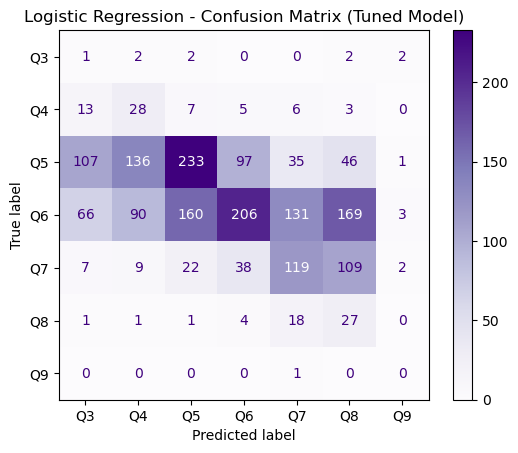

C:\Users\silla\AppData\Local\Temp\ipykernel_5208\1327573115.py:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


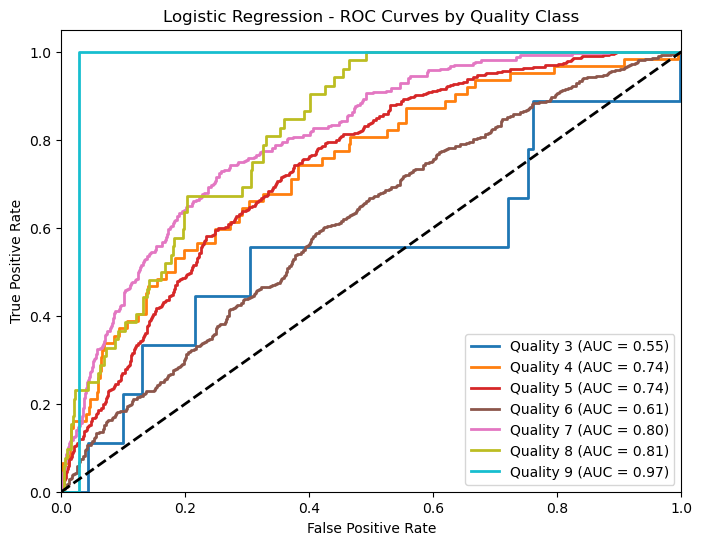

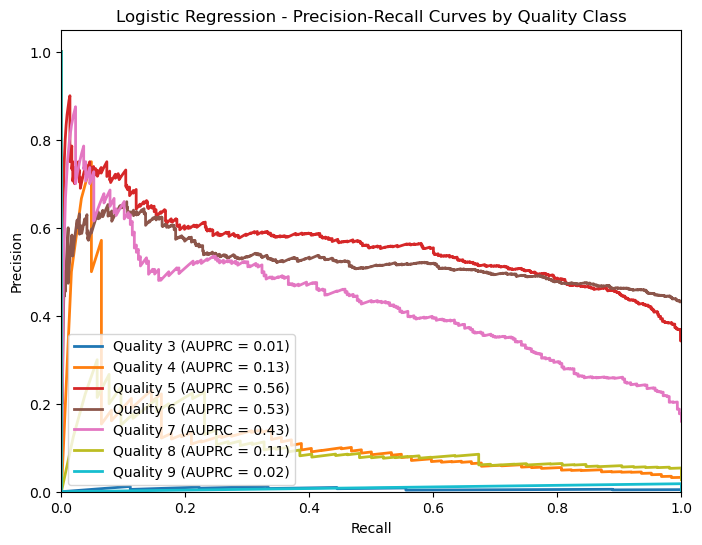

In [ ]:
# Logistic Regression with validation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning with GridSearchCV
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000],
    'solver': ['lbfgs', 'newton-cg']
}

# Create model
log_model = LogisticRegression(
    multi_class='multinomial', 
    random_state=42,
)

grid_search = GridSearchCV(
    log_model, 
    param_grid, 
    cv=5,  # Increased back to 5 due to SMOTE providing sufficient samples
    scoring='balanced_accuracy',  # Better for imbalanced data
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train_balanced)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")


from sklearn.model_selection import cross_val_score
# calculate metrics across CV for comparison
cv_accuracy_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_balanced, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

cv_f1_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_balanced, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

print(f"\nAccuracy across 5 CV folds:")
for i, score in enumerate(cv_accuracy_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean Accuracy: {cv_accuracy_scores.mean():.4f} ± {cv_accuracy_scores.std():.4f}")

print(f"\nF1-Score (macro) across 5 CV folds:")
for i, score in enumerate(cv_f1_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean F1-Score: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")

# Use best model
best_log_model = grid_search.best_estimator_

# Validation performance
y_val_pred = best_log_model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred = best_log_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

# Debug: Check predictions
print(f"Predictions range: {y_pred.min()} to {y_pred.max()}")
print(f"Unique predictions: {sorted(np.unique(y_pred))}")

# Check if any predictions are outside expected range (3-9)
invalid_preds = y_pred[(y_pred < 3) | (y_pred > 9)]
if len(invalid_preds) > 0:
    print(f"WARNING: Found {len(invalid_preds)} predictions outside range 3-9!")
    print(f"Invalid predictions: {invalid_preds}")
else:
    print( "All predictions are within valid range 3-9")
    
print(f"Logistic Regression Final Accuracy: {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")
    
# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

# Calculate AUROC and AUPRC scores
from sklearn.metrics import roc_auc_score, average_precision_score
y_pred_proba_temp = best_log_model.predict_proba(X_test_scaled)
auroc_macro = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='macro')
auroc_weighted = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='weighted')

# For AUPRC binarize and calculate per class
from sklearn.preprocessing import label_binarize
y_test_binarized_temp = label_binarize(y_test, classes=unique_classes)
auprc_scores = []
for i in range(len(unique_classes)):
    auprc = average_precision_score(y_test_binarized_temp[:, i], y_pred_proba_temp[:, i])
    auprc_scores.append(auprc)
auprc_macro = np.mean(auprc_scores)
auprc_weighted = np.average(auprc_scores, weights=[np.sum(y_test == cls) for cls in unique_classes])

print(f"AUROC (Macro): {auroc_macro:.4f}")
print(f"AUROC (Weighted): {auroc_weighted:.4f}")
print(f"AUPRC (Macro): {auprc_macro:.4f}")
print(f"AUPRC (Weighted): {auprc_weighted:.4f}")

# Calculate F1-score averages
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("Logistic Regression - Confusion Matrix (Tuned Model)")
plt.show()

# Plot the AUROC curve for multiclass classification
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize    
# Binarize the output labels for AUROC calculation
y_test_binarized = label_binarize(y_test, classes=unique_classes)
y_pred_proba = best_log_model.predict_proba(X_test_scaled)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(unique_classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])   
# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curves by Quality Class')
plt.legend(loc="lower right")
plt.show()

# Plot the AUPRC curve for multiclass classification
from sklearn.metrics import precision_recall_curve, average_precision_score
# Compute Precision-Recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
# Plot all Precision-Recall curves
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUPRC = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression - Precision-Recall Curves by Quality Class')
plt.legend(loc="lower left")
plt.show()


## K-Nearest-Neighbour


=== Hyperparameter Tuning ===
Note: With SMOTE balancing, KNN can now work effectively with balanced classes
Fitting 5 folds for each of 42 candidates, totalling 210 fits


Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV score: 0.8886

Accuracy across 5 CV folds:
  Fold 1: 0.8761
  Fold 2: 0.8779
  Fold 3: 0.8904
  Fold 4: 0.8904
  Fold 5: 0.9081
Mean Accuracy: 0.8886 ± 0.0115

F1-Score (macro) across 5 CV folds:
  Fold 1: 0.8698
  Fold 2: 0.8730
  Fold 3: 0.8844
  Fold 4: 0.8843
  Fold 5: 0.9003
Mean F1-Score: 0.8823 ± 0.0107

Accuracy across 5 CV folds:
  Fold 1: 0.8761
  Fold 2: 0.8779
  Fold 3: 0.8904
  Fold 4: 0.8904
  Fold 5: 0.9081
Mean Accuracy: 0.8886 ± 0.0115

F1-Score (macro) across 5 CV folds:
  Fold 1: 0.8698
  Fold 2: 0.8730
  Fold 3: 0.8844
  Fold 4: 0.8843
  Fold 5: 0.9003
Mean F1-Score: 0.8823 ± 0.0107
Validation accuracy: 0.6155
Validation accuracy: 0.6155
Test accuracy: 0.6414
KNN Final Accuracy (tuned): 0.641
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Overall Test Set R² Score: 0.0211
AUROC (Macro): 0.7005
AURO

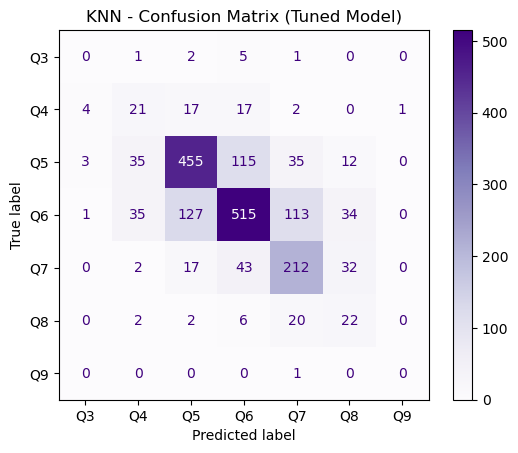

C:\Users\silla\AppData\Local\Temp\ipykernel_5208\2037587438.py:154: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


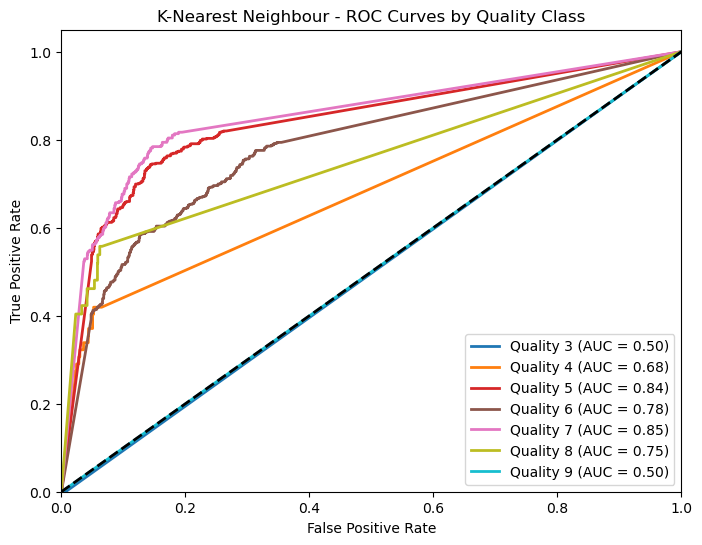

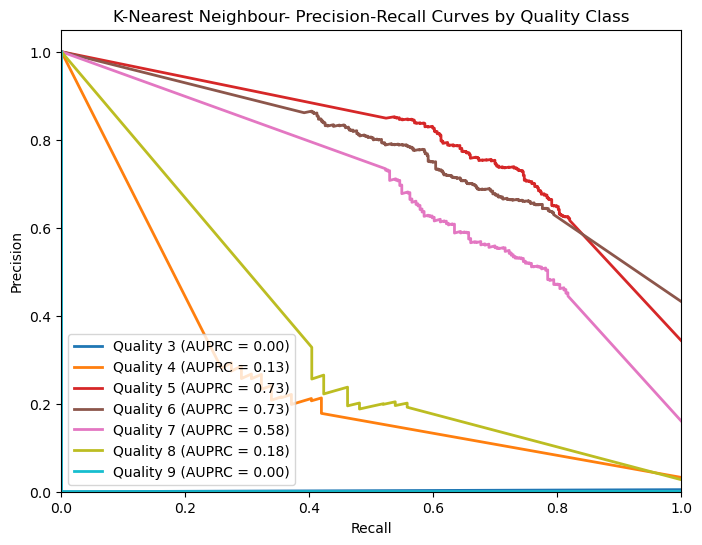

In [ ]:
# Using same data splits across models for consistency 
# Hyperparameter tuning with GridSearchCV
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_model = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn_model, 
    param_grid, 
    cv=5,  # Increased back to 5 due to SMOTE providing sufficient samples
    scoring='balanced_accuracy',  # Use balanced accuracy for imbalanced data
    n_jobs=-1,
    verbose=1
)

# Fit with balanced training data from SMOTE
grid_search.fit(X_train_scaled, y_train_balanced)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Also calculate other metrics across CV for comparison
cv_accuracy_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_balanced, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

cv_f1_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_balanced, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

print(f"\nAccuracy across 5 CV folds:")
for i, score in enumerate(cv_accuracy_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean Accuracy: {cv_accuracy_scores.mean():.4f} ± {cv_accuracy_scores.std():.4f}")

print(f"\nF1-Score (macro) across 5 CV folds:")
for i, score in enumerate(cv_f1_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean F1-Score: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")

# Use best model
best_knn_model = grid_search.best_estimator_

# Validation performance
y_val_pred = best_knn_model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred = best_knn_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

print(f"KNN Final Accuracy (tuned): {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")
    
# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

# Calculate AUROC and AUPRC scores
y_pred_proba_temp = best_knn_model.predict_proba(X_test_scaled)
auroc_macro = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='macro')
auroc_weighted = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='weighted')

# For AUPRC, calculate per class
y_test_binarized_temp = label_binarize(y_test, classes=unique_classes)
auprc_scores = []
for i in range(len(unique_classes)):
    auprc = average_precision_score(y_test_binarized_temp[:, i], y_pred_proba_temp[:, i])
    auprc_scores.append(auprc)
auprc_macro = np.mean(auprc_scores)
auprc_weighted = np.average(auprc_scores, weights=[np.sum(y_test == cls) for cls in unique_classes])

print(f"AUROC (Macro): {auroc_macro:.4f}")
print(f"AUROC (Weighted): {auroc_weighted:.4f}")
print(f"AUPRC (Macro): {auprc_macro:.4f}")
print(f"AUPRC (Weighted): {auprc_weighted:.4f}")

# Calculate F1-score averages
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("KNN - Confusion Matrix (Tuned Model)")
plt.show()

# Plot the AUROC curve for multiclass classification
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize    
# Binarize the output labels for AUROC calculation
y_test_binarized = label_binarize(y_test, classes=unique_classes)
y_pred_proba = best_knn_model.predict_proba(X_test_scaled)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(unique_classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])   
# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbour - ROC Curves by Quality Class')
plt.legend(loc="lower right")
plt.show()

# Plot the AUPRC curve for multiclass classification
from sklearn.metrics import precision_recall_curve, average_precision_score
# Compute Precision-Recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
# Plot all Precision-Recall curves
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUPRC = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('K-Nearest Neighbour- Precision-Recall Curves by Quality Class')
plt.legend(loc="lower left")
plt.show()


## Neural Network


=== Neural Network Hyperparameter Tuning ===
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 1000}
Best CV score: 0.8208
Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 1000}
Best CV score: 0.8208

Accuracy across 5 CV folds:
  Fold 1: 0.8025
  Fold 2: 0.8255
  Fold 3: 0.8038
  Fold 4: 0.8193
  Fold 5: 0.8531
Mean Accuracy: 0.8208 ± 0.0184

F1-Score (macro) across 5 CV folds:
  Fold 1: 0.7993
  Fold 2: 0.8203
  Fold 3: 0.7926
  Fold 4: 0.8072
  Fold 5: 0.8438
Mean F1-Score: 0.8126 ± 0.0181
Validation accuracy: 0.5348
Test accuracy: 0.5445
Neural Network Final Accuracy (tuned): 0.545
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Overall Test Set R² Score: -0.0336
AUROC (Macro): 0.7435
AUROC (Weighted): 0.7430
AUPRC (Macro): 

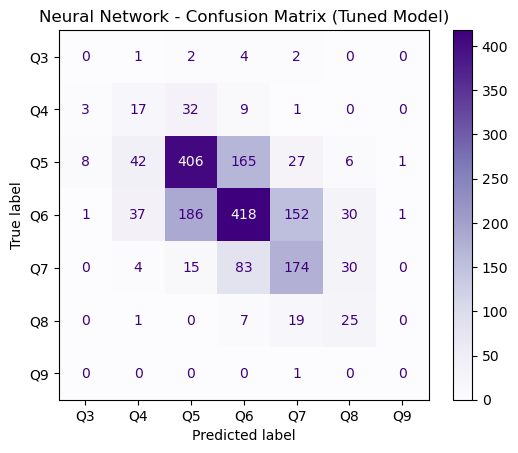

C:\Users\silla\AppData\Local\Temp\ipykernel_5208\138661920.py:153: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


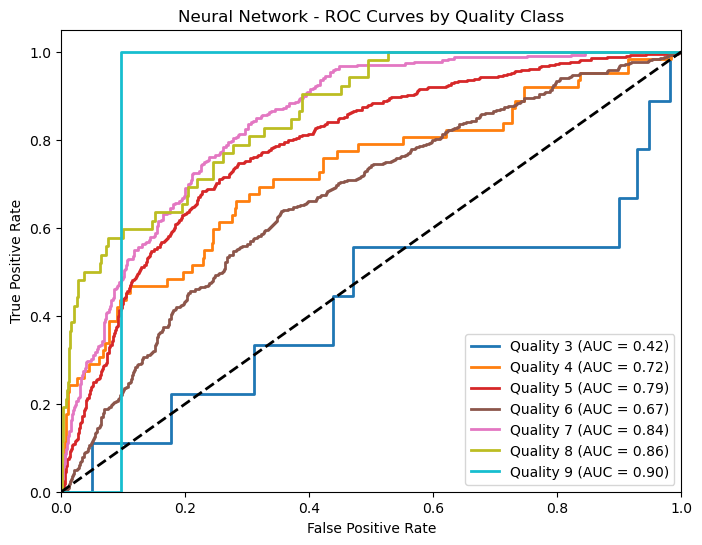

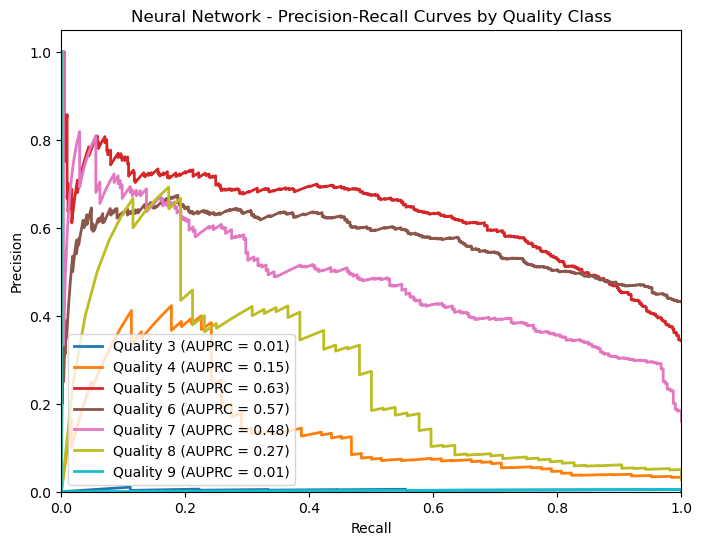

In [ ]:

# Hyperparameter tuning with GridSearchCV
print("\n=== Neural Network Hyperparameter Tuning ===")
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50), (12, 12, 12), (20, 20, 20)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000, 2000]
}

# With SMOTE balancing, neural network can now work with balanced classes
mlp_model = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)
grid_search = GridSearchCV(
    mlp_model, 
    param_grid, 
    cv=5,  # Increased back to 5 due to SMOTE providing sufficient samples
    scoring='balanced_accuracy',  # Use balanced accuracy for imbalanced data
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train_balanced)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Also calculate other metrics across CV for comparison
cv_accuracy_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_balanced, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

cv_f1_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_balanced, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

print(f"\nAccuracy across 5 CV folds:")
for i, score in enumerate(cv_accuracy_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean Accuracy: {cv_accuracy_scores.mean():.4f} ± {cv_accuracy_scores.std():.4f}")

print(f"\nF1-Score (macro) across 5 CV folds:")
for i, score in enumerate(cv_f1_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean F1-Score: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")

# Use best model
best_mlp_model = grid_search.best_estimator_

# Validation performance
y_val_pred = best_mlp_model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred = best_mlp_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

print(f"Neural Network Final Accuracy (tuned): {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")

# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

# Calculate AUROC and AUPRC scores
y_pred_proba_temp = best_mlp_model.predict_proba(X_test_scaled)
auroc_macro = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='macro')
auroc_weighted = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='weighted')

# For AUPRC, calculate per class
y_test_binarized_temp = label_binarize(y_test, classes=unique_classes)
auprc_scores = []
for i in range(len(unique_classes)):
    auprc = average_precision_score(y_test_binarized_temp[:, i], y_pred_proba_temp[:, i])
    auprc_scores.append(auprc)
auprc_macro = np.mean(auprc_scores)
auprc_weighted = np.average(auprc_scores, weights=[np.sum(y_test == cls) for cls in unique_classes])

print(f"AUROC (Macro): {auroc_macro:.4f}")
print(f"AUROC (Weighted): {auroc_weighted:.4f}")
print(f"AUPRC (Macro): {auprc_macro:.4f}")
print(f"AUPRC (Weighted): {auprc_weighted:.4f}")

# Calculate F1-score averages
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")
    
# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("Neural Network - Confusion Matrix (Tuned Model)")
plt.show()


# Plot the AUROC curve for multiclass classification
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize    
# Binarize the output labels for AUROC calculation
y_test_binarized = label_binarize(y_test, classes=unique_classes)
y_pred_proba = best_mlp_model.predict_proba(X_test_scaled)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(unique_classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])   
# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network - ROC Curves by Quality Class')
plt.legend(loc="lower right")
plt.show()

# Plot the AUPRC curve for multiclass classification
from sklearn.metrics import precision_recall_curve, average_precision_score
# Compute Precision-Recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
# Plot all Precision-Recall curves
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUPRC = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Neural Network - Precision-Recall Curves by Quality Class')
plt.legend(loc="lower left")
plt.show()


## Random Forest


=== Hyperparameter Tuning ===
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.9112
Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.9112

Accuracy across 5 CV folds:
  Fold 1: 0.8930
  Fold 2: 0.8987
  Fold 3: 0.9177
  Fold 4: 0.9133
  Fold 5: 0.9333
Mean Accuracy: 0.9112 ± 0.0143

F1-Score (macro) across 5 CV folds:
  Fold 1: 0.8929
  Fold 2: 0.8975
  Fold 3: 0.9156
  Fold 4: 0.9109
  Fold 5: 0.9302
Mean F1-Score: 0.9094 ± 0.0133
Validation accuracy: 0.6778

Accuracy across 5 CV folds:
  Fold 1: 0.8930
  Fold 2: 0.8987
  Fold 3: 0.9177
  Fold 4: 0.9133
  Fold 5: 0.9333
Mean Accuracy: 0.9112 ± 0.0143

F1-Score (macro) across 5 CV folds:
  Fold 1: 0.8929
  Fold 2: 0.8975
  Fold 3: 0.9156
  Fold 4: 0.9109
  Fold 5: 0.9302
Mean F1-Score:

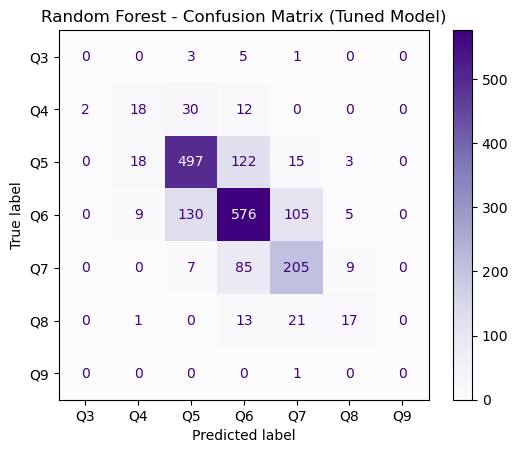

C:\Users\silla\AppData\Local\Temp\ipykernel_5208\1352620002.py:156: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


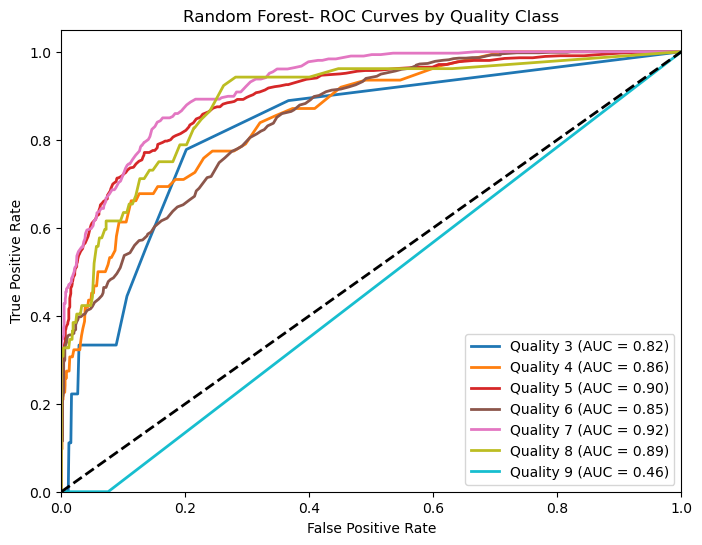

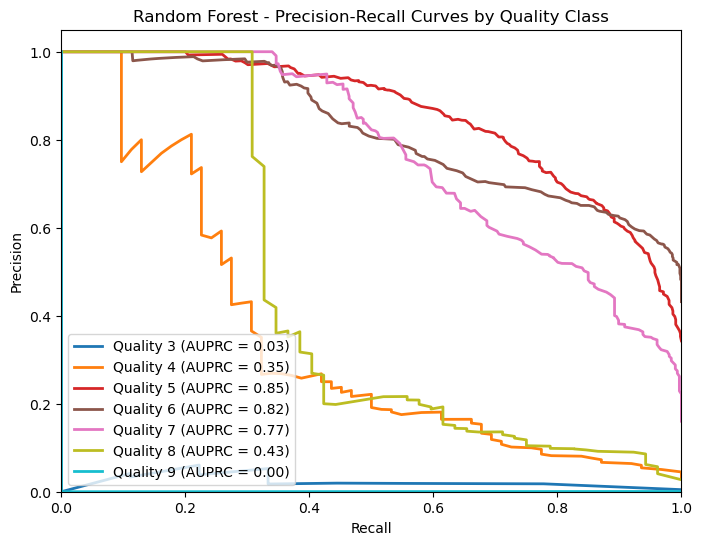

In [ ]:
# Hyperparameter tuning with GridSearchCV
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# With SMOTE balancing, Random Forest can work with balanced classes
rf_model = RandomForestClassifier(
    random_state=42
    # No class_weight needed since SMOTE already balanced the data
)
grid_search = GridSearchCV(
    rf_model, 
    param_grid, 
    cv=5,  # Increased back to 5 due to SMOTE providing sufficient samples
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train_balanced)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Also calculate other metrics across CV for comparison
cv_accuracy_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_balanced, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

cv_f1_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_balanced, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

print(f"\nAccuracy across 5 CV folds:")
for i, score in enumerate(cv_accuracy_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean Accuracy: {cv_accuracy_scores.mean():.4f} ± {cv_accuracy_scores.std():.4f}")

print(f"\nF1-Score (macro) across 5 CV folds:")
for i, score in enumerate(cv_f1_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean F1-Score: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")

# Use best model
best_rf_model = grid_search.best_estimator_

# Validation performance
y_val_pred = best_rf_model.predict(X_val_scaled)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred = best_rf_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

print(f"Random Forest Final Accuracy (tuned): {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")

# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

# Calculate AUROC and AUPRC scores
y_pred_proba_temp = best_rf_model.predict_proba(X_test_scaled)
auroc_macro = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='macro')
auroc_weighted = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='weighted')

# For AUPRC, calculate per class
y_test_binarized_temp = label_binarize(y_test, classes=unique_classes)
auprc_scores = []
for i in range(len(unique_classes)):
    auprc = average_precision_score(y_test_binarized_temp[:, i], y_pred_proba_temp[:, i])
    auprc_scores.append(auprc)
auprc_macro = np.mean(auprc_scores)
auprc_weighted = np.average(auprc_scores, weights=[np.sum(y_test == cls) for cls in unique_classes])

print(f"AUROC (Macro): {auroc_macro:.4f}")
print(f"AUROC (Weighted): {auroc_weighted:.4f}")
print(f"AUPRC (Macro): {auprc_macro:.4f}")
print(f"AUPRC (Weighted): {auprc_weighted:.4f}")

# Calculate F1-score averages
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("Random Forest - Confusion Matrix (Tuned Model)")
plt.show()

# Plot the AUROC curve for multiclass classification
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize    
# Binarize the output labels for AUROC calculation
y_test_binarized = label_binarize(y_test, classes=unique_classes)
y_pred_proba = best_rf_model.predict_proba(X_test_scaled)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(unique_classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])   
# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest- ROC Curves by Quality Class')
plt.legend(loc="lower right")
plt.show()

# Plot the AUPRC curve for multiclass classification
from sklearn.metrics import precision_recall_curve, average_precision_score
# Compute Precision-Recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
# Plot all Precision-Recall curves
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUPRC = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest - Precision-Recall Curves by Quality Class')
plt.legend(loc="lower left")
plt.show()


## XGBoost

Original quality values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Encoded to: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
XGBoost will use balanced training data from SMOTE (no additional sample weights needed)

=== Hyperparameter Tuning ===
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
Best CV score: 0.8878
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
Best CV score: 0.8878

Accuracy across 5 CV folds:
  Fold 1: 0.8463
  Fold 2: 0.8714
  Fold 3: 0.8978
  Fold 4: 0.8921
  Fold 5: 0.9315
Mean Accuracy: 0.8878 ± 0.0284

F1-Score (macro) across 5 CV folds:
  Fold 1: 0.8512
  Fold 2: 0.8713
  Fold 3: 0.8947
  Fold 4: 0.8880
  Fold 5: 0.9289
Mean F1-Score: 0.8868 ± 0.0259
Validation ac

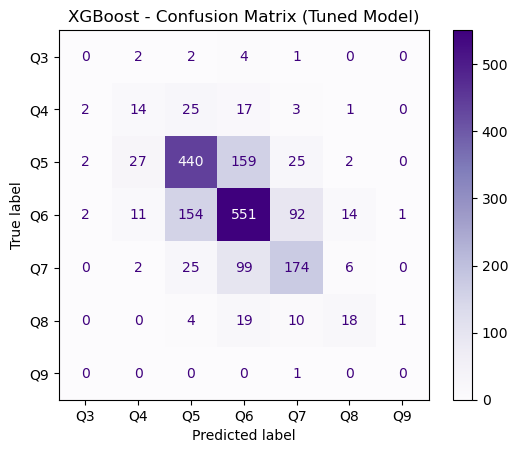

C:\Users\silla\AppData\Local\Temp\ipykernel_5208\2055939691.py:175: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


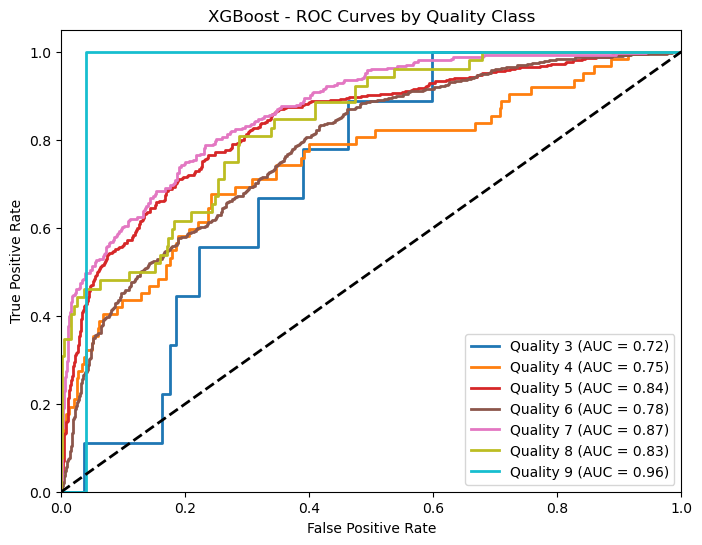

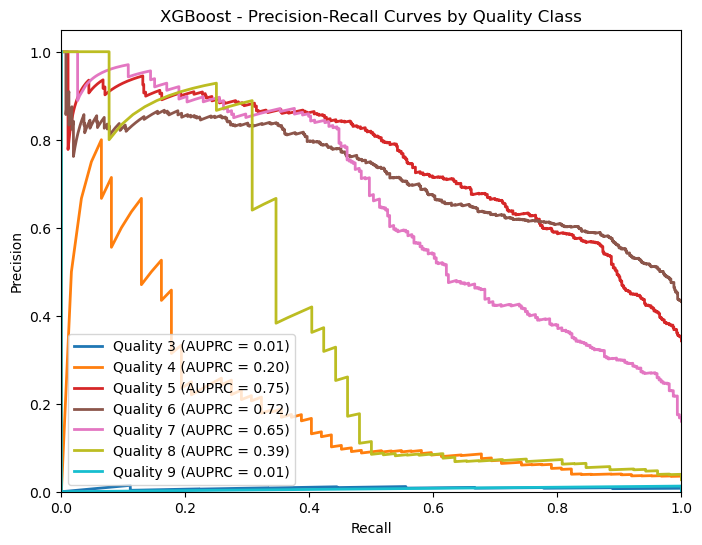


Feature Importance Ranking:
chlorides                : 0.2593
residual sugar           : 0.2047
volatile acidity         : 0.1970
sulphates                : 0.1705
citric acid              : 0.1686


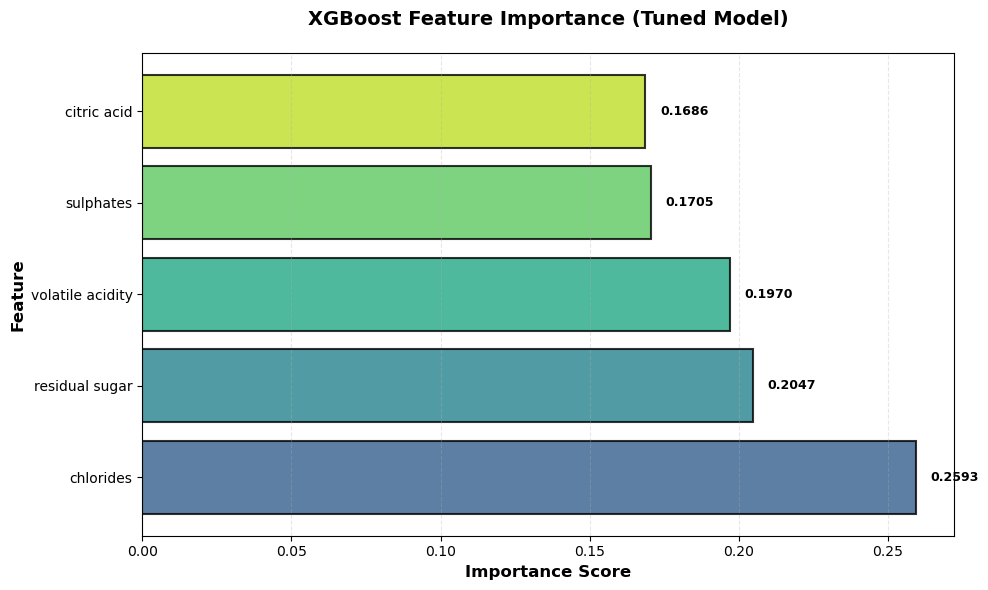


✅ Top 3 most important features:
  5. chlorides (0.2593)
  1. residual sugar (0.2047)
  3. volatile acidity (0.1970)


In [ ]:
# Import XGBoost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode quality labels to 0-indexed format (XGBoost requirement)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Original quality values: {sorted(y_train.unique())}")
print(f"Encoded to: {sorted(np.unique(y_train_encoded))}")

print("XGBoost will use balanced training data from SMOTE (no additional sample weights needed)")

# Hyperparameter tuning with GridSearchCV
print("\n=== Hyperparameter Tuning ===")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)

grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=5,  # Increased back to 5 due to SMOTE providing sufficient samples
    scoring='balanced_accuracy',  # Use balanced accuracy for imbalanced data
    n_jobs=-1,
    verbose=1
)

# Fit with balanced training data from SMOTE
grid_search.fit(X_train_scaled, y_train_encoded)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Also calculate other metrics across CV for comparison
cv_accuracy_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_encoded, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

cv_f1_scores = cross_val_score(
    grid_search.best_estimator_, 
    X_train_scaled, 
    y_train_encoded, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1
)

print(f"\nAccuracy across 5 CV folds:")
for i, score in enumerate(cv_accuracy_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean Accuracy: {cv_accuracy_scores.mean():.4f} ± {cv_accuracy_scores.std():.4f}")

print(f"\nF1-Score (macro) across 5 CV folds:")
for i, score in enumerate(cv_f1_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"Mean F1-Score: {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")

# Use best model
best_xgb_model = grid_search.best_estimator_

# Validation performance
y_val_pred_encoded = best_xgb_model.predict(X_val_scaled)
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc:.4f}")

# Final test performance
y_pred_encoded = best_xgb_model.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.4f}")

print(f"XGBoost Final Accuracy (tuned): {test_acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")

# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

# Calculate AUROC and AUPRC scores
y_pred_proba_temp = best_xgb_model.predict_proba(X_test_scaled)
auroc_macro = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='macro')
auroc_weighted = roc_auc_score(y_test, y_pred_proba_temp, multi_class='ovr', average='weighted')

# For AUPRC, calculate per class
y_test_binarized_temp = label_binarize(y_test, classes=unique_classes)
auprc_scores = []
for i in range(len(unique_classes)):
    auprc = average_precision_score(y_test_binarized_temp[:, i], y_pred_proba_temp[:, i])
    auprc_scores.append(auprc)
auprc_macro = np.mean(auprc_scores)
auprc_weighted = np.average(auprc_scores, weights=[np.sum(y_test == cls) for cls in unique_classes])

print(f"AUROC (Macro): {auroc_macro:.4f}")
print(f"AUROC (Weighted): {auroc_weighted:.4f}")
print(f"AUPRC (Macro): {auprc_macro:.4f}")
print(f"AUPRC (Weighted): {auprc_weighted:.4f}")

# Calculate F1-score averages
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Quality {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with actual quality values
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{cls}' for cls in unique_classes])
disp.plot(cmap="Purples", values_format="d")
plt.title("XGBoost - Confusion Matrix (Tuned Model)")
plt.show()

# Plot the AUROC curve for multiclass classification
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize    
# Binarize the output labels for AUROC calculation
y_test_binarized = label_binarize(y_test, classes=unique_classes)
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(unique_classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])   
# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost - ROC Curves by Quality Class')
plt.legend(loc="lower right")
plt.show()

# Plot the AUPRC curve for multiclass classification
from sklearn.metrics import precision_recall_curve, average_precision_score
# Compute Precision-Recall curve and AUPRC for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
# Plot all Precision-Recall curves
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Quality {unique_classes[i]} (AUPRC = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost - Precision-Recall Curves by Quality Class')
plt.legend(loc="lower left")
plt.show()


## Feature Importance for Each Model

Features to be analyzed: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']

=== XGBoost SHAP Analysis ===
Quality 3 corresponds to index 4 in SHAP values
Quality 3 corresponds to index 4 in SHAP values


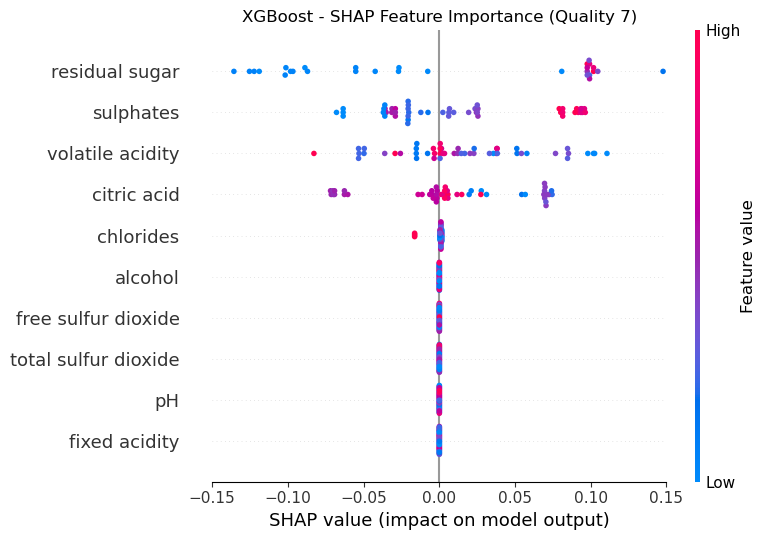

In [99]:
!pip install shap 
import shap

# Get feature names for proper labeling in SHAP plots
feature_names = X.columns.tolist()
print(f"Features to be analyzed: {feature_names}")

# # ============== Logistic Regression ====================
# print("\n=== Logistic Regression SHAP Analysis ===")
# # Use the new API that returns Explanation objects
# explainer = shap.Explainer(best_log_model.predict_proba, X_train_scaled[:100], feature_names=feature_names)
# shap_values = explainer(X_test_scaled[:50])  # This returns an Explanation object
# shap.plots.beeswarm(shap_values[:,:,0], show=False)
# plt.title("Logistic Regression - SHAP Feature Importance (Quality Class 0)")
# plt.tight_layout()
# plt.show()

# # ============== KNN ====================
# print("\n=== K-Nearest Neighbors SHAP Analysis ===")
# explainer = shap.Explainer(best_knn_model.predict_proba, X_train_scaled[:100], feature_names=feature_names)
# shap_values = explainer(X_test_scaled[:50])
# shap.plots.beeswarm(shap_values[:,:,0], show=False)
# plt.title("K-Nearest Neighbors - SHAP Feature Importance (Quality Class 0)")
# plt.tight_layout()
# plt.show()

# # ============== MLP ====================
# print("\n=== Neural Network SHAP Analysis ===")
# explainer = shap.Explainer(best_mlp_model.predict_proba, X_train_scaled[:100], feature_names=feature_names)
# shap_values = explainer(X_test_scaled[:50])
# shap.plots.beeswarm(shap_values[:,:,0], show=False)
# plt.title("Neural Network - SHAP Feature Importance (Quality Class 0)")
# plt.tight_layout()
# plt.show()

# # ============== RF ====================
# print("\n=== Random Forest SHAP Analysis ===")
# Use unscaled data for tree-based models as they work better with original data
X_train_unscaled = X_train_balanced[:100]  # Use unscaled balanced training data
X_test_unscaled = X_val[:50]  # Use unscaled validation data for analysis
# explainer = shap.Explainer(best_rf_model, X_train_unscaled, feature_names=feature_names, check_additivity=False)
# shap_values = explainer(X_test_unscaled, check_additivity=False)
# shap.plots.beeswarm(shap_values[:,:,0], show=False)
# plt.title("Random Forest - SHAP Feature Importance (Quality Class 0)")
# plt.tight_layout()
# plt.show()

# ============== XGB ====================
print("\n=== XGBoost SHAP Analysis ===")
# Use unscaled data for XGBoost as well
explainer = shap.Explainer(best_xgb_model, X_train_unscaled, feature_names=feature_names)
shap_values = explainer(X_test_unscaled, check_additivity=False)

# Determine the index for quality class 3
# XGBoost uses label encoding, so we need to find which index corresponds to quality 3
quality_3_index = label_encoder.transform([7])[0]  # Get the encoded index for quality 3
print(f"Quality 3 corresponds to index {quality_3_index} in SHAP values")

shap.plots.beeswarm(shap_values[:,:,quality_3_index], show=False)
plt.title("XGBoost - SHAP Feature Importance (Quality 7)")
plt.xlim(-0.15, 0.15)
plt.tight_layout()
plt.show()